# Single-Cell RNA Sequencing using synthetic dataset generated from Splatter

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Generate Synthetic Dataset using Splatter

The core of the Splat model is a gamma-Poisson distribution used to generate a gene by cell matrix of counts. Mean expression levels for each gene are simulated from a gamma distribution and the Biological Coefficient of Variation is used to enforce a mean-variance trend before counts are simulated from a Poisson distribution. Splat also allows you to simulate expression outlier genes (genes with mean expression outside the gamma distribution) and dropout (random knock out of counts based on mean expression). Each cell is given an expected library size (simulated from a log-normal distribution) that makes it easier to match to a given dataset. Splat can also simulate differential expression between groups of different types of cells or differentiation paths between different cells types where expression changes in a continuous way.


In [8]:
# %%R will execute R command
# -o flag gives a way to transfer R variables to Jupyter Notebook

In [9]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo
library(splatter)
# Reference: https://bioconductor.org/packages/devel/bioc/vignettes/splatter/inst/doc/splatter.html
simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups # Group Probability

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

R[write to console]: Getting parameters...

R[write to console]: Creating simulation object...

R[write to console]: Simulating library sizes...

R[write to console]: Simulating gene means...

R[write to console]: Simulating group DE...

R[write to console]: Simulating cell means...

R[write to console]: Simulating BCV...

R[write to console]: Simulating counts...

R[write to console]: Simulating dropout (if needed)...

R[write to console]: Done!



In [21]:
counts[1:4]

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
Cell2,0,36,0,406,27,270,216,0,126,0,...,23,224,666,0,4,165,390,0,0,104
Cell3,26,96,0,367,21,365,304,10,305,0,...,0,263,740,0,0,0,510,1471,7,100
Cell4,12,43,0,321,0,198,258,20,147,0,...,21,178,426,0,0,127,261,1609,0,104


In [22]:
type(counts[1:4])

pandas.core.frame.DataFrame

In [19]:
truecounts[1:4]

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
Cell2,33,36,8,406,27,270,216,37,126,15,...,23,224,666,7,4,165,390,1214,5,104
Cell3,26,96,7,367,21,365,304,10,305,8,...,12,263,740,1,5,154,510,1471,7,100
Cell4,12,43,2,321,12,198,258,20,147,10,...,21,178,426,3,4,127,261,1609,3,104


In [20]:
type(truecounts[1:4])

pandas.core.frame.DataFrame

In [24]:
import pandas as pd

In [26]:
raw_read_count = pd.read_csv("data/blakeley/Blakeley_raw_data.csv") 

In [38]:
genes = raw_read_count.columns.values

In [39]:
genes

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30'], dtype=object)

In [43]:
cells = raw_read_count.index

In [44]:
cells

Index(['A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1', 'A4GALT',
       'A4GNT', 'AA06', 'AAAS',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23794)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [47]:
adata = sc.AnnData(raw_read_count)


In [48]:
adata

AnnData object with n_obs × n_vars = 23794 × 30 

RecursionError: maximum recursion depth exceeded while getting the str of an object

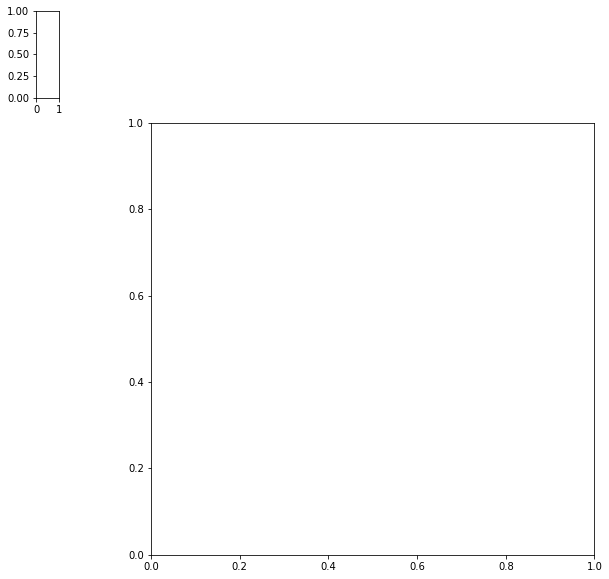

In [49]:
sc.pl.clustermap(adata)